# TP2: Filter Banks

By Daniel Jorge Deutsch, Kevin Kühl and Brayam Santiago Velandia (03/10/2020)

In [1]:
import os
import struct
import sys
import time
import warnings
import wave
from copy import deepcopy
from math import ceil
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile
from scipy.linalg import hankel
from scipy.linalg import norm
from scipy.linalg import inv

In [2]:
class Base:

    def __init__(self, name, tdata=None, freq=None, mag=None):

        if not ((tdata is None) ^ (freq is None or mag is None)):
            raise Exception("You must provide a tdata or a freq and mag arrays")
        if not(freq is None or mag is None):
            if len(freq) != len(mag):
                raise Exception("freq and mag arrays must be of the same length")
        
        self.name = name

        # Time domain attributes
        if not(tdata is None):
            self.tdata = np.asarray(tdata)
        else:
            self.tdata = np.fft.ifft(mag)

        # Frequency domain attributes
        if not(freq is None or mag is None):
            self.freq = np.asarray(freq)
            self.mag = np.asarray(mag)
        else:
            len_fft = 4096                                                           # Length of the transformed axis of the output
            self.freq, self.mag = sig.freqz(self.tdata, worN=len_fft, whole=True)    # Obtains the frequency and magnitude
            self.freq = self.freq/(2*np.pi)                                          # Converts the frequency to (rad/sample)/2π

    
    #------------------------------#
    #--- SAMPLES ------------------#
    #------------------------------#

    def step_split_sample(self, step):
        tdatas = [self.tdata[i::step] for i in range(step)]
        max_len = max([len(tdata) for tdata in tdatas])
        for i, tdata in enumerate(tdatas):
            if len(tdata) != max_len:
                tdatas[i] = np.append(tdata, 0)
            tdatas[i] = self.__class__(f"{self.name}{i}", tdatas[i])
        return tuple(tdatas) 


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
    
    def data_plot(self, discrete=False, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the xaxis
        xaxis = np.abs(self.tdata) if absolute else self.tdata
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Plot of {self.name}")
        plt.stem(xaxis) if discrete else plt.plot(xaxis)
        plt.xlim(0, len(xaxis)-1)
        plt.ylabel("Amplitude")
        plt.xlabel("Index")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_data.png", dpi=300, bbox_inches="tight")
        plt.show()


    def spectrogram_plot(self, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the spectrogram params
        f, t, Sxx = sig.spectrogram(self.tdata, self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Spectogram of {self.name}")
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading="auto")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_spectrogram.png", dpi=300, bbox_inches="tight")
        plt.show()


    def freqz_plot(self, whole=False, absolute=True, db=True, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Frequency
        freq = self.freq

        # Magnitude
        mag = np.abs(self.mag) if absolute else self.mag
        mag = 20*np.log10(mag) if db else mag
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        if not whole:
            mag = mag[:int(len(mag)/2)]
            freq = freq[:int(len(freq)/2)]
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Frequency response of {self.name}")
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]") if db else plt.ylabel("Magnitude")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

In [3]:
class Signal(Base):

    def __init__(self, name, tdata=None, freq=None, mag=None, fs=None, file=None):
        if not ((tdata is None) ^ (file == None)):
            raise Exception("You must provide a tdata or a .wav file")
        if file:
            fs, tdata = wavfile.read(file)
        self.fs = int(fs) if fs else fs
        Base.__init__(self, name, tdata)


    #------------------------------#
    #--- SHIFTING -----------------#
    #------------------------------#

    def shift(self, name, power_of_z):
        tdata = self.tdata
        tdata = np.append(tdata[power_of_z:], power_of_z*[0]) if power_of_z > 0 else np.append(abs(power_of_z)*[0], tdata[:power_of_z])
        return self.__class__(name, tdata=tdata, fs=self.fs)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def under_sample(self, name, M):
        tdatas = self.step_split_sample(M)
        if self.fs:
            return self.__class__(name=name, tdata=tdatas[0].tdata, fs=self.fs/M)
        else:
            return self.__class__(name=name, tdata=tdatas[0].tdata)
        

    def over_sample(self, name, L):
        tdata = np.insert(self.tdata, range(1, len(self.tdata)+1)[::L-1], 0)
        if self.fs:
            return self.__class__(name=name, tdata=tdata, fs=self.fs*L) 
        else:
            return self.__class__(name=name, tdata=tdata) 

    #------------------------------#
    #--- PLOT ---------------------#
    #------------------------------#

    def time_plot(self, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Obtains the time axis
        t = np.linspace(0, len(self.tdata)/self.fs, len(self.tdata))

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Time plot of {self.name}")
        plt.plot(t, np.abs(self.tdata)) if absolute else plt.plot(t, self.tdata)            
        plt.xlim(t[0], t[-1])
        plt.ylabel("Amplitude")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.hlines(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()
            

    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#

    def listen(self):
        
        # Saves the .wav
        if not self.fs:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.fs, np.asarray(self.tdata, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [4]:
class Filter(Base):

    def apply(self, name, signal):
        conv = np.convolve(self.tdata, signal.tdata)
        return Signal(name, tdata=conv, fs=signal.fs)

# 1.1

In [47]:
def cqf_analysis_filterbank(x, h0):
    N = h0.tdata.size
    signal = (-1.0)**(np.arange(N))
    h1=h0.tdata[::-1]*signal
    h1 = Filter("h1", tdata=h1)
    
    xx = np.zeros(len(x.tdata) + len(h0.tdata) - 1)

    xx[0:len(x.tdata)] = x.tdata

    x0 = Signal("x0", tdata=sig.lfilter(h0.tdata,[1],xx))
    x1 = Signal("x1", tdata=sig.lfilter(h1.tdata,[1],xx))


    v0 = x0.under_sample("v0", 2)
    v1 = x1.under_sample("v1", 2)
    
    return [v0, v1]

# 1.2

In [48]:
def cqf_synthesis_filterbank(v0, v1, h0):
    N = h0.tdata.size
    signal = (-1.0)**(np.arange(N))
    h1=h0.tdata[::-1]*signal
    h1 = Filter("h1", tdata=h1)
    f0 = h0.tdata[::-1]
    f1 = h1.tdata[::-1]
    f0 = Filter("f0", tdata=f0) 
    f1 = Filter("f1", tdata=f1)
    u0 = v0.over_sample("u0", 2)
    u1 = v1.over_sample("u1", 2)
    y0 = Signal("y0", tdata=sig.lfilter(f0.tdata,[1],u0.tdata))
    y1 = Signal("y1", tdata=sig.lfilter(f1.tdata,[1],u1.tdata))
    y = Signal("y", tdata=y0.tdata + y1.tdata)
    return y

# 1.3

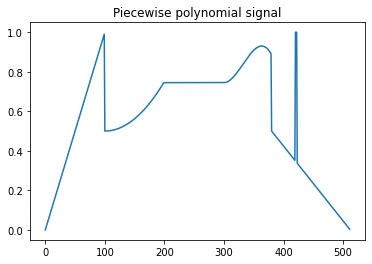

In [49]:
x=np.zeros(512)
N1 = 100
N2 = 200
N3 = 300
N4 = 380
N5 = 512
r1 = np.arange(0,N1)
r2 = np.arange(N1,N2)
r3 = np.arange(N2,N3)
r4 = np.arange(N3,N4)
r5 = np.arange(N4,N5)
x[r1] = r1/float(N1)
x[r2] =0.5+ ((r2-float(N1))/float(N2))**2
x[r3] = x[N2-1]
t4 = (r4-float(N3))/float(N4)
x[r4] = -80*t4**3 + 20*t4**2 + x[N2-1]
x[r5] = 0.5*(1-(r5-float(N4))/(float(N5-N4)))
x[420:423] =1
plt.plot(x)
plt.title("Piecewise polynomial signal")
plt.show()

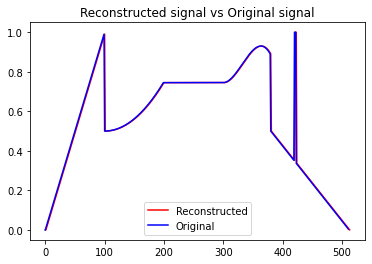

Relative error: 1.2797703641191922e-12


In [50]:
# First defining h0 as the Haar filter
h0 = np.zeros(2)
h0[0] = 0.707106781187
h0[1] = 0.707106781187
h0 = Filter("h0", tdata=h0)

x_haar = Signal("x_haar", tdata=x)

v0, v1 = cqf_analysis_filterbank(x_haar,h0)
y_haar = cqf_synthesis_filterbank(v0,v1,h0)
plt.plot(y_haar.tdata, color="red")
plt.plot(x, color="blue")
plt.legend(["Reconstructed", "Original"])
plt.title("Reconstructed signal vs Original signal")
plt.show()
print("Relative error: {}".format(np.linalg.norm(x-y_haar.tdata[h0.tdata.size-1:x.size+h0.tdata.size-1])/np.linalg.norm(x)))

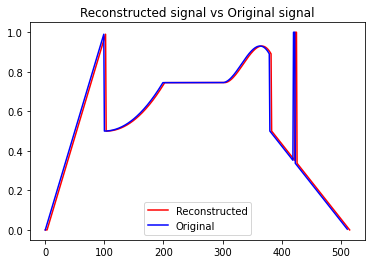

Relative error: 1.2770113573497566e-12


In [51]:
# First defining h0 as the Daubechies filter
h0 = np.zeros(4)
h0[0] = 0.482962913145
h0[1] = 0.836516303738
h0[2] = 0.224143868042
h0[3] = -0.129409522551

h0 = Filter("h0", tdata=h0)

x_daubechies = Signal("x_daubechies", tdata=x)

v0, v1 = cqf_analysis_filterbank(x_daubechies,h0)
y_daubechies = cqf_synthesis_filterbank(v0,v1,h0)
plt.plot(y_daubechies.tdata, color="red")
plt.plot(x, color="blue")
plt.legend(["Reconstructed", "Original"])
plt.title("Reconstructed signal vs Original signal")
plt.show()
print("Relative error: {}".format(np.linalg.norm(x-y_daubechies.tdata[h0.tdata.size-1:x.size+h0.tdata.size-1])/np.linalg.norm(x)))

# 1.4
Yes, we achieve perfect reconstruction, what can be comproved by the relative error displayed above.

# 1.5

In [52]:
print("For the Haar Filter, printing the last M-1 values and the last zero")
print()
print(y_haar.tdata[x.size:])
print()
print("For the Daubechies Filter, printing the last M-1 values and the last zero")
print()
print(y_daubechies.tdata[x.size:])

For the Haar Filter, printing the last M-1 values and the last zero

[0.00378788 0.        ]

For the Daubechies Filter, printing the last M-1 values and the last zero

[1.13636364e-02 7.57575758e-03 3.78787879e-03 2.20396618e-15]


We can see that terms that were zero at the zero padded original signal, are now different from zero. The last element of the reconstructed signal will be zero because of our filterbank implementation.

For Haar Filter (with size 2), 1 coefficient is introduced.
For Daubechies Filter (with size 4), 3 coefficients are introduced.

# 1.6

In [53]:
def cqf_analysis_filterbank_periodisation(x, h0):
    N = h0.tdata.size
    signal = (-1.0)**(np.arange(N))
    h1=h0.tdata[::-1]*signal
    h1 = Filter("h1", tdata=h1)
    xx = np.zeros(len(x.tdata) + len(h0.tdata) - 1)

    xx[0:len(x.tdata)] = x.tdata
    x_per = np.concatenate([xx]*3, axis=0)

    x0 = Signal("x0", tdata=sig.lfilter(h0.tdata,[1],x_per))
    x1 = Signal("x1", tdata=sig.lfilter(h1.tdata,[1],x_per))


    v0 = x0.under_sample("v0", 2)
    v1 = x1.under_sample("v1", 2)
    
    return (v0, v1)

def cqf_synthesis_filterbank_periodisation(v0, v1, h0):
    N = h0.tdata.size
    signal = (-1.0)**(np.arange(N))
    h1=h0.tdata[::-1]*signal
    h1 = Filter("h1", tdata=h1)
    f0 = h0.tdata[::-1]
    f1 = h1.tdata[::-1]
    f0 = Filter("f0", tdata=f0) 
    f1 = Filter("f1", tdata=f1)
    u0 = v0.over_sample("u0", 2)
    u1 = v1.over_sample("u1", 2)
    y0 = Signal("y0", tdata=sig.lfilter(f0.tdata,[1],u0.tdata))
    y1 = Signal("y1", tdata=sig.lfilter(f1.tdata,[1],u1.tdata))
    y = Signal("y", tdata=y0.tdata + y1.tdata)
    return Signal("y",tdata=y.tdata[len(y.tdata)//3:2*len(y.tdata)//3])

513


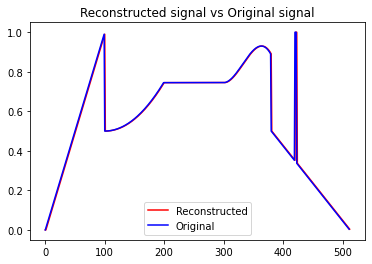

512
Relative error: 0.1144044175726436


In [54]:
h0 = np.zeros(2)
h0[0] = 0.707106781187
h0[1] = 0.707106781187

h0 = Filter("h0", tdata=h0)

x_haar = Signal("x_haar", tdata=x)

v0, v1 = cqf_analysis_filterbank_periodisation(x_daubechies,h0)
y_haar = cqf_synthesis_filterbank_periodisation(v0,v1,h0)
print(y_haar.tdata.size)
plt.plot(y_haar.tdata, color="red")
plt.plot(x, color="blue")
plt.legend(["Reconstructed", "Original"])
plt.title("Reconstructed signal vs Original signal")
plt.show()
print(x.size)
print("Relative error: {}".format(np.linalg.norm(x-y_daubechies.tdata[h0.tdata.size-1:x.size+h0.tdata.size-1])/np.linalg.norm(x)))

515


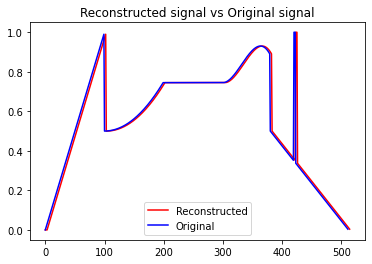

512
Relative error: 1.277001766605939e-12


In [55]:
h0 = np.zeros(4)
h0[0] = 0.482962913145
h0[1] = 0.836516303738
h0[2] = 0.224143868042
h0[3] = -0.129409522551

h0 = Filter("h0", tdata=h0)

x_daubechies = Signal("x_daubechies", tdata=x)

v0, v1 = cqf_analysis_filterbank_periodisation(x_daubechies,h0)
y_daubechies = cqf_synthesis_filterbank_periodisation(v0,v1,h0)
print(y_daubechies.tdata.size)
plt.plot(y_daubechies.tdata, color="red")
plt.plot(x, color="blue")
plt.legend(["Reconstructed", "Original"])
plt.title("Reconstructed signal vs Original signal")
plt.show()
print(x.size)
print("Relative error: {}".format(np.linalg.norm(x-y_daubechies.tdata[h0.tdata.size-1:x.size+h0.tdata.size-1])/np.linalg.norm(x)))

In [56]:
print("For the Haar Filter, printing the last M-1 values and the last zero")
print()
print(y_haar.tdata[x.size:])
print()
print("For the Daubechies Filter, printing the last M-1 values and the last zero")
print()
print(y_daubechies.tdata[x.size:])

For the Haar Filter, printing the last M-1 values and the last zero

[0.00378788]

For the Daubechies Filter, printing the last M-1 values and the last zero

[0.01136364 0.00757576 0.00378788]


# 1.7

We will use the Dubechies Filter

In [68]:
def MRA(x, h0, nLev):
    
    u0, u1 = cqf_analysis_filterbank(x, h0)
    
    if (nLev==0):
        return x
    
    return (MRA(u0, h0, nLev-1), u1)

values = MRA(x_daubechies,h0,6)

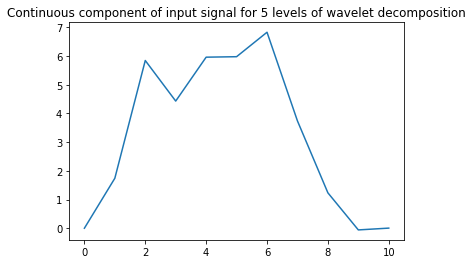

In [69]:
plt.plot(values[0][0][0][0][0][0].tdata)
plt.title('Continuous component of input signal for 5 levels of wavelet decomposition')
plt.show()

In [72]:
print(values[0][0][0][0][0][0].tdata.size)

11
